100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.5MB/s]


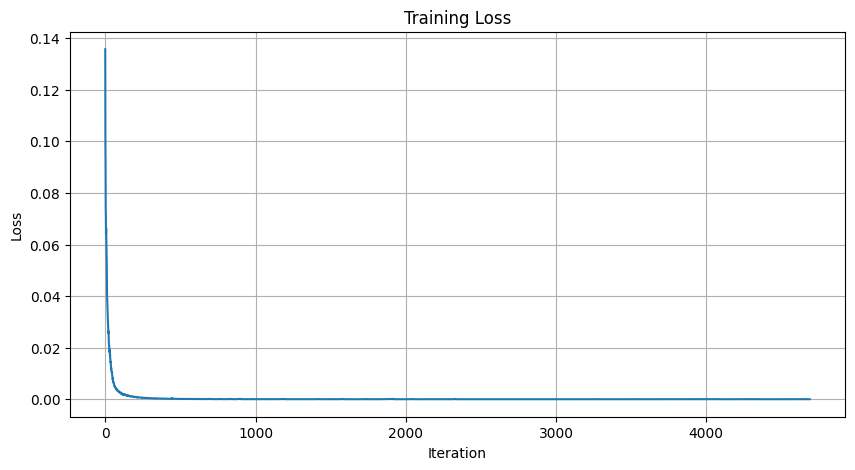

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a simplified DiT block with adaptive layer norm (adaLN-Zero inspired)
class AdaLNZero(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.scale = nn.Parameter(torch.zeros(dim))
        self.shift = nn.Parameter(torch.zeros(dim))
        self.ln = nn.LayerNorm(dim)

    def forward(self, x):
        return self.ln(x) * self.scale + self.shift

class SimpleDiTBlock(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.norm1 = AdaLNZero(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.norm2 = AdaLNZero(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x, _ = self.attn(x, x, x)
        x = x + residual

        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        return x + residual

# Build a simple DiT with patchify and transformer blocks
class SimpleDiT(nn.Module):
    def __init__(self, patch_size, in_channels, emb_dim, depth, heads):
        super().__init__()
        self.patch_size = patch_size
        self.embed = nn.Conv2d(in_channels, emb_dim, patch_size, patch_size)
        self.transformer = nn.Sequential(*[SimpleDiTBlock(emb_dim, heads) for _ in range(depth)])
        self.decode = nn.ConvTranspose2d(emb_dim, in_channels, patch_size, patch_size)

    def forward(self, x):
        x = self.embed(x)  # [B, D, H/P, W/P]
        b, d, h, w = x.shape
        x = x.permute(0, 2, 3, 1).reshape(b, -1, d)  # [B, N, D]
        x = self.transformer(x)
        x = x.reshape(b, h, w, d).permute(0, 3, 1, 2)  # [B, D, H/P, W/P]
        return self.decode(x)

# Load MNIST for simplicity and fast training
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor()
])
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Initialize model
model = SimpleDiT(patch_size=4, in_channels=1, emb_dim=64, depth=2, heads=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train for 5 epochs
losses = []
for epoch in range(5):
    for x, _ in train_loader:
        x = x.to(device)
        output = model(x)
        loss = loss_fn(output, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


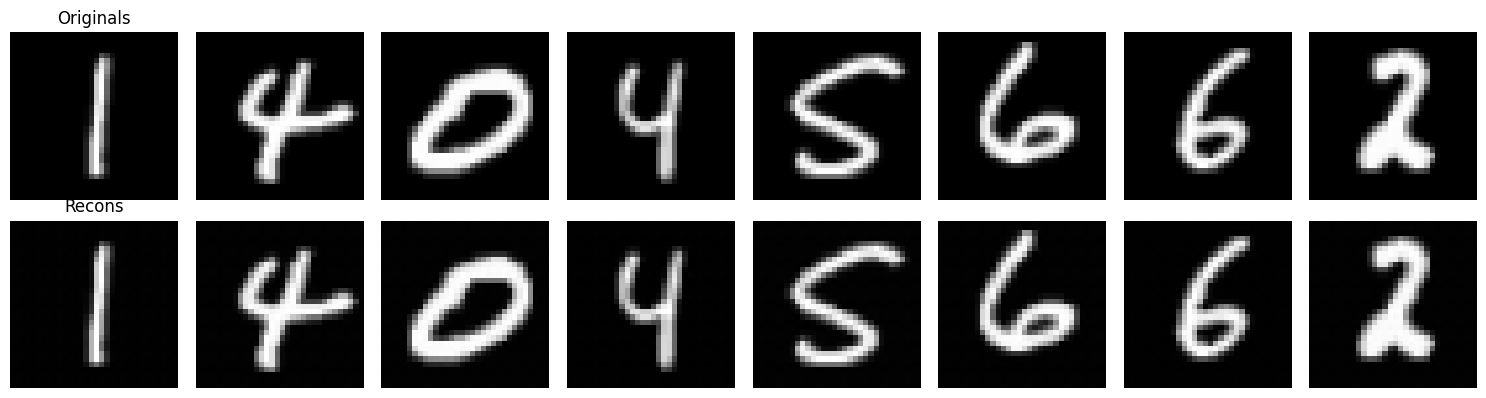

In [2]:
import numpy as np

# Get a mini-batch
x_batch, _ = next(iter(train_loader))
x_batch = x_batch.to(device)[:8]
with torch.no_grad():
    recon = model(x_batch)

# Plot originals vs reconstructions
fig, axs = plt.subplots(2, 8, figsize=(15, 4))
for i in range(8):
    axs[0, i].imshow(x_batch[i].cpu().squeeze(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(recon[i].cpu().squeeze(), cmap='gray')
    axs[1, i].axis('off')
axs[0, 0].set_title("Originals")
axs[1, 0].set_title("Recons")
plt.tight_layout()
plt.show()


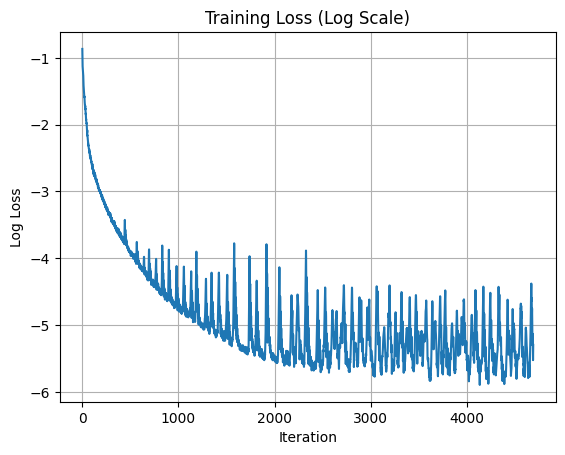

In [3]:
plt.figure()
plt.plot(np.log10(losses))
plt.title("Training Loss (Log Scale)")
plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.grid(True)
plt.show()


In [4]:
# Beta schedule (linear), 1000 steps
T = 1000
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1. - betas
alpha_hat = torch.cumprod(alphas, dim=0)

# Add noise to clean image x at timestep t
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    sqrt_alpha_hat_t = alpha_hat[t].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_hat_t = (1 - alpha_hat[t]).sqrt().view(-1, 1, 1, 1)
    return sqrt_alpha_hat_t * x_0 + sqrt_one_minus_alpha_hat_t * noise, noise


In [8]:
model.train()
denoise_losses = []

for epoch in range(20):
    for x, _ in train_loader:
        x = x.to(device)

        t = torch.randint(0, T, (x.size(0),), device=device).long()
        x_noised, noise = q_sample(x, t)

        noise_pred = model(x_noised)  # Predict noise directly!
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        denoise_losses.append(loss.item())


In [9]:
@torch.no_grad()
def sample(model, n=8):
    model.eval()
    x_t = torch.randn(n, 1, 32, 32).to(device)  # Start from noise

    for t in reversed(range(T)):
        t_batch = torch.full((n,), t, device=device, dtype=torch.long)
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_hat_t = alpha_hat[t]

        noise_pred = model(x_t)
        if t > 0:
            noise = torch.randn_like(x_t)
        else:
            noise = torch.zeros_like(x_t)

        x_t = (1 / alpha_t.sqrt()) * (x_t - (1 - alpha_t) / (1 - alpha_hat_t).sqrt() * noise_pred) + beta_t.sqrt() * noise
    return x_t


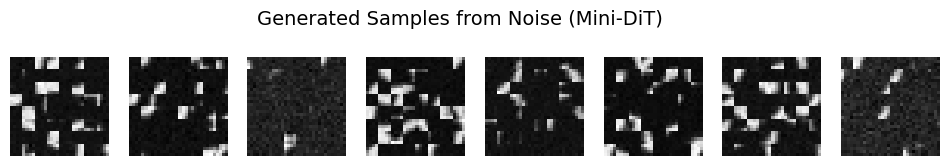

In [10]:
samples = sample(model, n=8)

plt.figure(figsize=(12, 2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(samples[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Generated Samples from Noise (Mini-DiT)", fontsize=14)
plt.show()
